In [1]:
import pandas as pd
import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
BLOCK_SIZE_X=8
BLOCK_SIZE_Y=8

# Heat equation in 2D
The heat equation can be written
$$
\begin{align}
\frac{\partial u}{\partial t} &= \kappa \nabla^2 u\\
&=\kappa \left[ \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2} \right]
\end{align}
$$
where $u$ is the temperature, and $\kappa$ is the material specific heat conduction constant. 

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we get
$$
\frac{1}{\Delta t} (u_{i, j}^{n+1} - u_{i, j}^{n}) 
= \kappa \left [
\frac{1}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{1}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
\right]
$$
and gathering $u^n+1$ on the left hand side and $u^n$on the right, we write
$$
u^{n+1}_{i,j} = u_{i,j}^n 
+ \frac{\kappa\Delta t}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{\kappa\Delta t}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
$$
This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta x^2}, \qquad
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta y^2}
$$
or 
$$
\Delta t \lt \text{min}\left(\frac{\Delta x^2}{2\kappa}, \frac{\Delta y^2}{2\kappa}\right)
$$


In [4]:
def plotting_function(u):
    u=u.reshape(ny,nx)
    plt.imshow(u.squeeze())
    fig = plt.figure()

In [5]:
nx=100
ny=50
initial_temp=np.zeros((ny,nx)).astype(np.float32)
kappa=1
dx=1
dy=2
dt = 0.4*min(dx**2 / (2.0*kappa), dy**2 / (2.0*kappa))
for j in range(ny):
    for i in range(nx):
        x = (i - nx/2.0) * dx
        y = (j - ny/2.0) * dy
        if (np.sqrt(x**2 + y**2) < 10*min(dx, dy)):
            initial_temp[j, i] = 10.0
initial_temp=initial_temp.flatten()

In [6]:
heat_eqn_kernel_src = """
__global__ void heatEqn2D(
            float* u1, 
            float* u0,
            float kappa, 
            float dt,
            float dx,
            float dy,
            unsigned int nx,
            unsigned int ny) {

    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    int center = j*nx + i;
    int north =(j+1)*nx+i;
    int south=(j-1)*nx+i;
    int east=j*nx + (i+1);
    int west=j*nx + (i-1);
    
            if(i>0 && i<nx-1 && j>0 && j<ny-1){
                u1[center] = u0[center]
                + kappa*dt/(dx*dx) * (u0[west] - 2*u0[center] + u0[east])
                + kappa*dt/(dy*dy) * (u0[south]-2*u0[center]+u0[north]);
            }
        
            else{ 
                u1[center] = u0[center];
                }
}
"""

mod = SourceModule(heat_eqn_kernel_src)
heatEqnGPU = mod.get_function("heatEqn2D")


def heatEquationGPU(u0,kappa,dt,dx,dy,num_timesteps):
    
    
    assert(u0.dtype == np.float32)    
    #We have u0 - initial temperatures. Need to make space for u1
    #Also make u0 on the GPU and upload from CPU
    u1_gpu = cuda.mem_alloc(u0.nbytes)
    u0_gpu=cuda.mem_alloc(u0.nbytes)
    cuda.memcpy_htod(u0_gpu,u0)

    #Compute block and grid size:
    block=(BLOCK_SIZE_X, BLOCK_SIZE_Y,1)
    grid=(int(np.ceil(nx/BLOCK_SIZE_X)),int(np.ceil(ny/BLOCK_SIZE_Y)),1)
                
    
    
    #We use n as the time index, and i and j as the space-indeces
    #First a for-loop for the time dimension
    for n in range(num_timesteps):
        #Compute u1 from u0
        # A for-loop for the space-dimension
        #Loop over all "internal" cells. 
        #Move to GPU!!!
        #Kernel function arguments:  float* u1, 
        #float* u0,
        #float kappa, 
        #float dx,
        #float dt,
        #float dy,
        #unsigned int nx
        #unsigned int ny
        
        heatEqnGPU(u1_gpu, u0_gpu, np.float32(kappa), np.float32(dt), np.float32(dx),
                   np.float32(dy),np.uint32(nx),np.uint32(ny), block=block, grid=grid)
        #Swap the new and old temperatures
        u0_gpu, u1_gpu = u1_gpu, u0_gpu
        if(n%50==0):
            u2=np.empty_like(u0)
            cuda.memcpy_dtoh(u2, u0_gpu)
            plotting_function(u2)
        
    
    #Download u0 - new temperatures from the GPU to the CPU. 
    u1 = np.empty_like(u0)
    cuda.memcpy_dtoh(u1, u0_gpu)
    
    #Return the updated temperatures
    return u1
    
 



/home/pgap3/anaconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


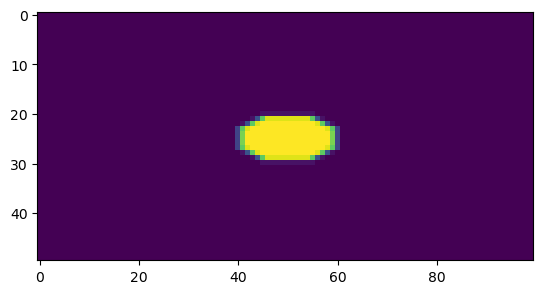

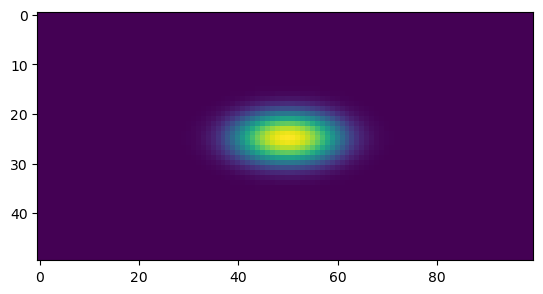

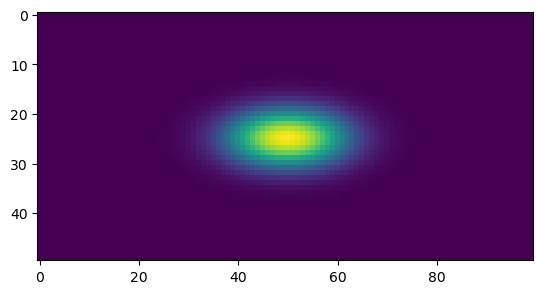

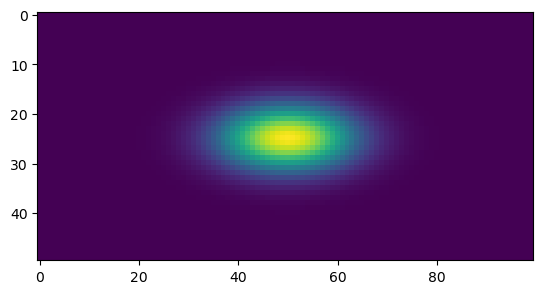

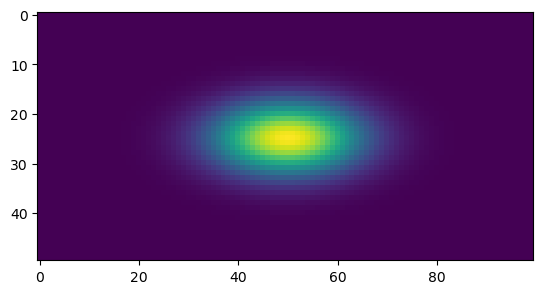

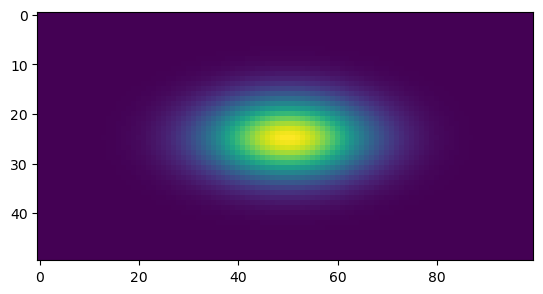

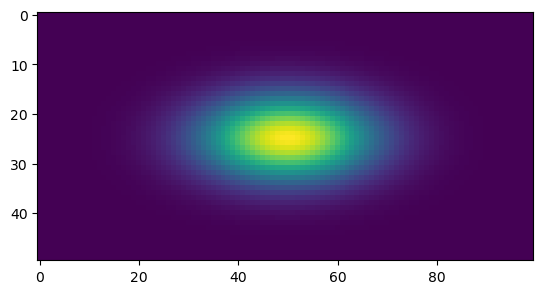

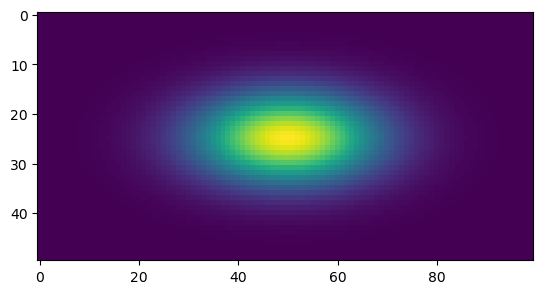

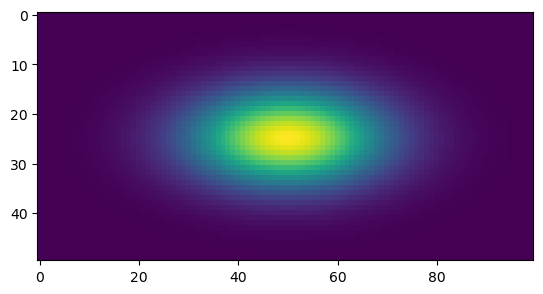

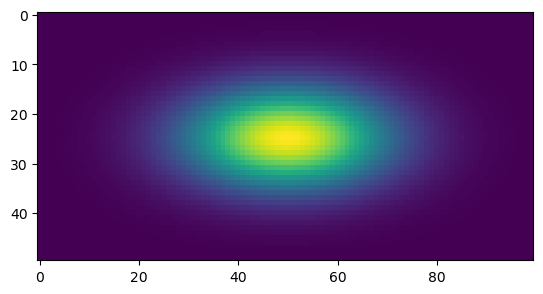

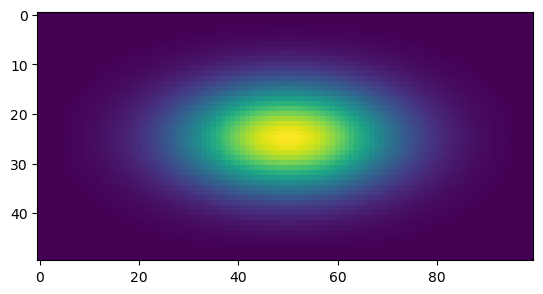

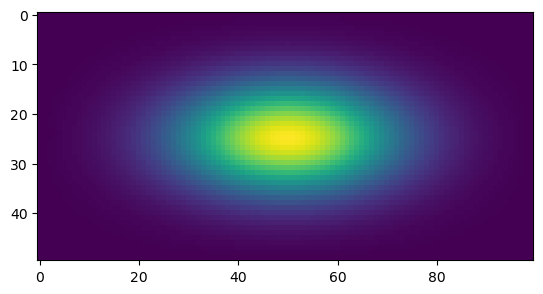

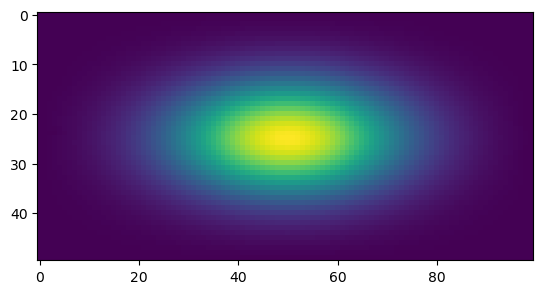

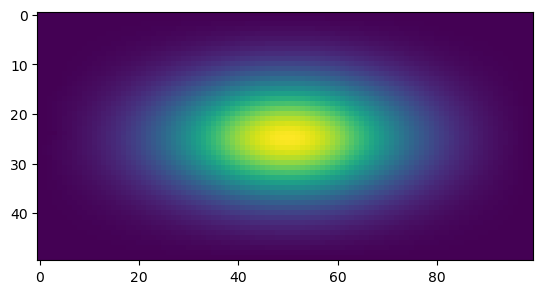

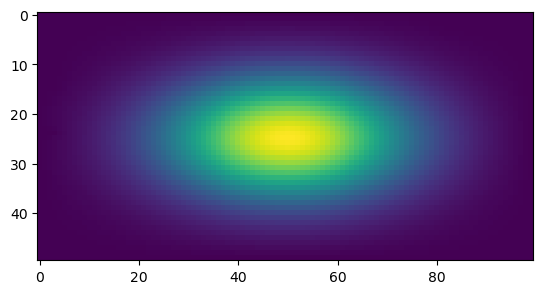

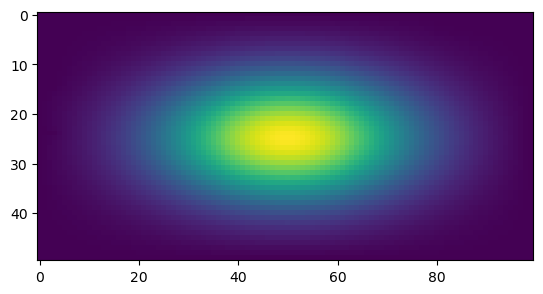

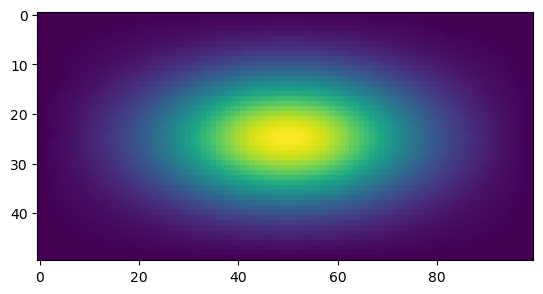

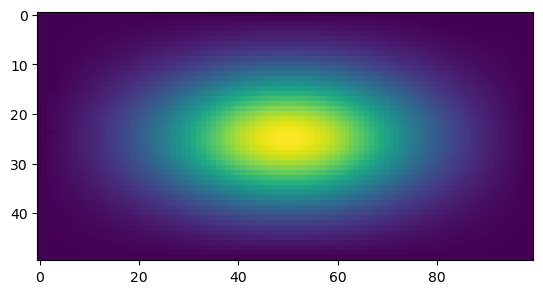

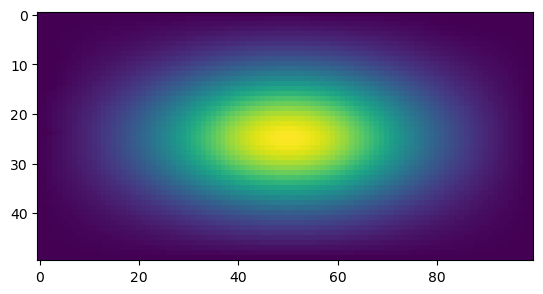

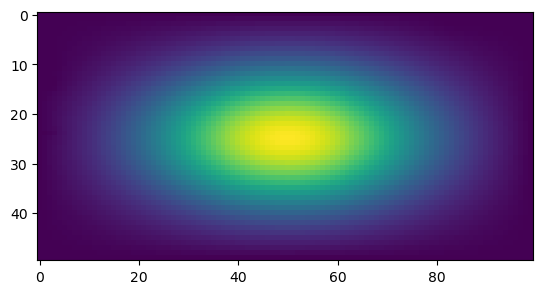

<Figure size 640x480 with 0 Axes>

In [7]:
u1 = heatEquationGPU(u0=initial_temp.copy(), kappa=kappa,dt=dt,dx=dx,dy=dy,num_timesteps=1000)